In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from src.augmentations import CustomAugmentations

import numpy as np
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [2]:
height,width=32,32
batch_size=9

In [4]:
from src.augmentations.CustomAugmentations import CustomAugmentationsTF

p_dicts = []
for aug_type in p_dict.keys():
    p_d = {aug_type: 1.0}
    p_dicts.append(p_d)
p_dicts.append(p_dict)

# Create an instance of CustomAugmentations
custom_aug = CustomAugmentationsTF(p_dict)


In [5]:
import matplotlib.pyplot as plt

In [6]:
class_names = original_dataset.class_names

In [7]:
def get_nth_batch(dataset, n):
    batch_generator = iter(dataset.batch(1))
    for _ in range(n):
        next(batch_generator)
    features = next(batch_generator)
    # print(features[1])
    return features[0], features[1]

In [8]:
batch_number = 3

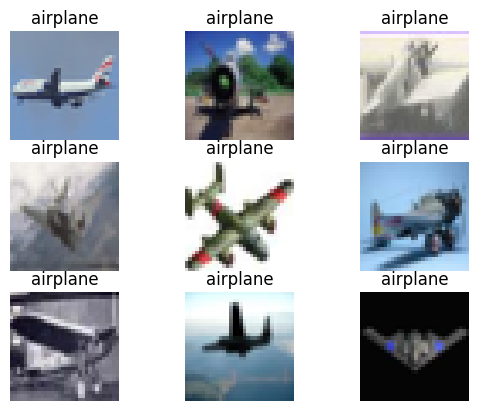

In [9]:
batch = get_nth_batch(original_dataset, batch_number)
images, labels = batch[0], batch[1]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0][i].numpy().astype("uint8"))
    plt.axis("off")
    # add label
    plt.title(class_names[labels[0][i]])


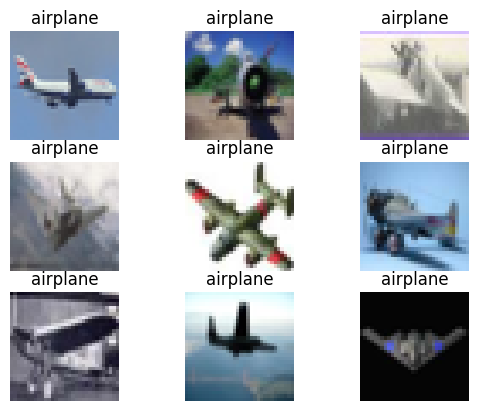

In [10]:
augmented = original_dataset.map(lambda image, label: (custom_aug.augment(image), label))

batch = get_nth_batch(augmented, batch_number)
images, labels = batch[0], batch[1]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0][i].numpy().astype("uint8"))
    plt.axis("off")
    # add label
    plt.title(class_names[labels[0][i]])


In [257]:
from copy import deepcopy
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


histories = list()
accuracies = list()
class_accuracies = list()
conf_mats = list()

for i in tqdm(range(5)):
    train_set = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/CINIC10/train",
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(height, width),
        shuffle=True,
        seed=i,
        validation_split=0.05,
        subset="training",
    )

    val_set = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/CINIC10/valid",
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(height, width),
        shuffle=True,
        seed=i,
        validation_split=0.05,
        subset="validation",
    )

    test_set = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/CINIC10/test",
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(height, width),
        shuffle=False,
    )

    dnn_model = Sequential()
    imported_model = tf.keras.applications.EfficientNetV2L(
        include_top=False,
        input_shape=(height, width, 3),
        pooling="max",
        classes=10,
        weights="imagenet",
    )

    dnn_model.add(imported_model)
    dnn_model.add(Flatten())
    dnn_model.add(Dense(2048, activation="relu"))
    dnn_model.add(Dense(1024, activation="relu"))
    dnn_model.add(Dense(10, activation="softmax"))

    dnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    print(f"Fitting model {i}")
    history = dnn_model.fit(train_set, validation_data=val_set, epochs=10)

    print(f"Predicting model {i}")
    preds = dnn_model.predict(test_set, verbose=2)
    preds = preds.argmax(axis=1)
    classes = test_set.class_names
    test_labels = list()
    for images, labels in test_set:
        class_labels = [int(label) for label in labels]
        test_labels.extend(class_labels)
    test_labels = np.array(test_labels)

    conf_mat = confusion_matrix(test_labels, preds)
    accuracy = accuracy_score(test_labels, preds)
    print(f"Accuracy: {accuracy} for model {i}")
    class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)

    print(f"Saving model {i}")
    dnn_model.save(f"../models/EfficientNetV2L_no_aug_{i}.h5")
    histories.append(deepcopy(history.history))
    accuracies.append(accuracy)
    class_accuracies.append(class_accuracy)
    conf_mats.append(conf_mat)


# save histories
import pickle

with open("results/HISTORY_EfficientNetV2L_no_aug.pkl", "wb") as f:
    pickle.dump(histories, f)

# save accuracies
with open("results/ACCURACY_EfficientNetV2L_no_aug.pkl", "wb") as f:
    pickle.dump(accuracies, f)

# save class accuracies
with open("results/CLASS_ACCURACY_EfficientNetV2L_no_aug.pkl", "wb") as f:
    pickle.dump(class_accuracies, f)

# save confusion matrices
with open("results/CONF_MAT_EfficientNetV2L_no_aug.pkl", "wb") as f:
    pickle.dump(conf_mats, f)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 